# Lab 2: Bayes classifier on the iris dataset

We will try to classify flowers from Fisher's Iris dataset. The dataset contains the measurements of *length* and *width* of the *sepals* and *petals* of 150 flowers.

![Petal and sepal in Iris flowers](Petal-sepal.jpg)

Using the distribution of these 4 features (*length* and *width* of both *sepals* and *petals*), the flowers can then be classified as one of 3 species of Iris flower:

* Iris setosa
* Iris versicolor
* Iris virginica

## 1. Getting to know the data

The dataset is stored as a dictionary, a data structure in Python that resembles a Java(script) object. We can access items in the dictionary with a dot `.`, so we access the data and their target labels with `iris.data` and `iris.target`, these are both NumPy arrays. If we want to know what each digit means, we can access the names with `iris.target_names`.

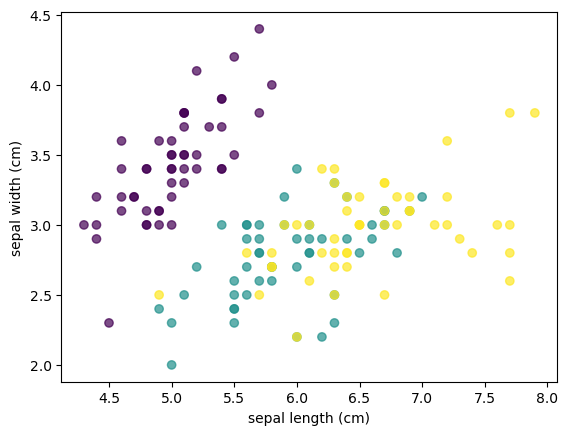

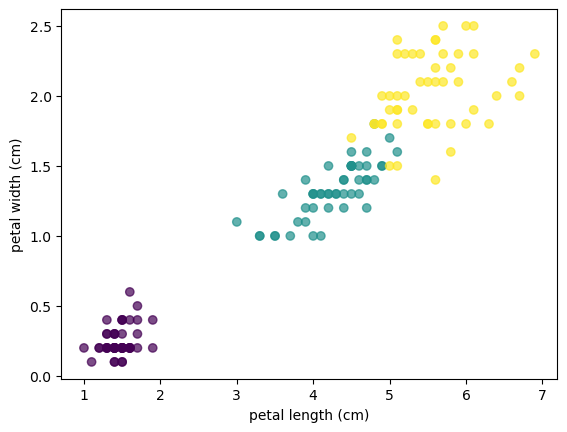

In [5]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

iris = datasets.load_iris()

# Create a scatterplot of the first two features, and use their labels as colour values.
plt.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target, alpha=0.7)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()
# Create a scatterplot of the third and fourth feature.
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, alpha=0.7)
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.show()

### 2. Separate the flower sets

In [12]:
setosaArr = [i == 0 for i in iris.target]
setosa_flowers = iris.data[setosaArr]

versiArr = [i == 0 for i in iris.target]
versicolor_flowers = iris.data[versiArr]

virgiArr = [i == 0 for i in iris.target]
virginica_flowers = iris.data[virgiArr]

### 3. Split train and test set

In [13]:
from sklearn.model_selection import train_test_split #to split in train and test set

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=20)

# Separate the training dataset into the three flower types.
setoFilter = [i == 0 for i in Y_train]
setosa_X_train = X_train[setoFilter]

versFilter = [i == 1 for i in Y_train]
versicolor_X_train = X_train[versFilter]

virgFilter = [i == 2 for i in Y_train]
virginica_X_train = X_train[virgFilter]

assert setosa_X_train.shape[0] != versicolor_X_train.shape[0]
assert setosa_X_train.shape[0] != virginica_X_train.shape[0]
assert versicolor_X_train.shape[0] != virginica_X_train.shape[0]

setosa_X_train.shape, versicolor_X_train.shape, virginica_X_train.shape

((37, 4), (32, 4), (36, 4))

## 4. Univariate model

Looking at the plots of the data from the previous section, you might assume that separating the different classes would be a lot easier based on the petal data (3rd and 4th variable) than on the sepal data (1st and 2nd variable), as it is easier to distinguish the different clusters in that plot. In fact, for now we will only focus on one variable, the petal length (3rd feature), as it looks like it might be useful just on its own and this will simplify the model a lot.

In [14]:
# We use the third feature
feature_idx = 2

Let's first take a look at the distribution of all flowers (both train and test) along this feature to confirm that our assumption of a normal distribution is correct. Take a look at the ditribution of the other features as well.

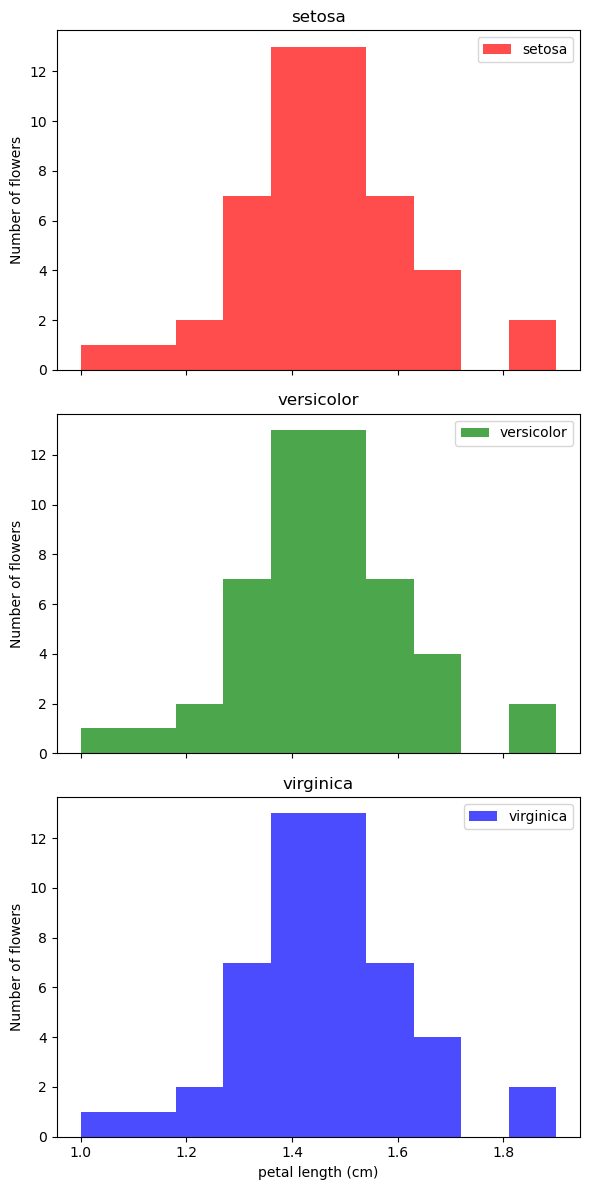

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)

axs[0].hist(setosa_flowers[:, feature_idx], label=iris.target_names[0], alpha=0.7, color="red")
axs[0].set_title(iris.target_names[0])

axs[1].hist(versicolor_flowers[:, feature_idx], label=iris.target_names[1], alpha=0.7, color="green")
axs[1].set_title(iris.target_names[1])

axs[2].hist(virginica_flowers[:, feature_idx], label=iris.target_names[2], alpha=0.7, color="blue")
axs[2].set_title(iris.target_names[2])

for ax in axs:
    ax.set_ylabel('Number of flowers')
    ax.legend()

axs[-1].set_xlabel(iris.feature_names[feature_idx])
plt.tight_layout()
plt.show()


That looks about correct! Now, let's find the parameters of the normal distribution that describe our data best. The parameters that we need to describe the distribution are the _mean_ and _standard deviation_.

$$\mu = \frac{\sum_{t=1}^Nx_t}{N}$$

$$\sigma = \sqrt{\frac{\sum_{t=1}^N(x_t - \mu)^2}{N}}$$

In [24]:
def compute_mean(x):
    mean = np.mean(x)
    return mean
    
def compute_sd(x, mean):
    sd = 0
    for i in x:
        sd += np.power(i - mean, 2)
    return np.sqrt(sd / len(x))

# Compute the mean for each flower type.
mean_setosa = compute_mean(setosa_X_train[:, feature_idx])
mean_versicolor = compute_mean(versicolor_X_train[:, feature_idx])
mean_virginica = compute_mean(virginica_X_train[:, feature_idx])

# Compute the standard deviation for each flower type.
sd_setosa = compute_sd(setosa_X_train[:, feature_idx], mean_setosa)
sd_versicolor = compute_sd(versicolor_X_train[:, feature_idx], mean_versicolor)
sd_virginica = compute_sd(virginica_X_train[:, feature_idx], mean_virginica)

# Print the computed means and standard deviations.
print("setosa", mean_setosa, sd_setosa)
print("versicolor", mean_versicolor, sd_versicolor)
print("virginica", mean_virginica, sd_virginica)

assert np.isclose(mean_setosa, 1.4729729729729728), "Expected a different mean"
assert np.isclose(mean_versicolor, 4.25), "Expected a different mean"
assert np.isclose(mean_virginica, 5.572222222222222), "Expected a different mean"

assert np.isclose(sd_setosa, 0.17652600857089654), "Expected a different standard deviation"
assert np.isclose(sd_versicolor, 0.44300112866673375), "Expected a different standard deviation"
assert np.isclose(sd_virginica, 0.547017728288333), "Expected a different standard deviation"

setosa 1.4729729729729728 0.17652600857089654
versicolor 4.25 0.4430011286667338
virginica 5.572222222222222 0.5470177282883328


## 5. Probability density function

$$p(x|\mu, \sigma)=\frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

That means that if we have estimates for $\mu$ and $\sigma$, we can compute the probability density for a specific value $x$.

Your pdf function outcome:  0.008863696823876015  Scipy's function outcome:  0.008863696823876015


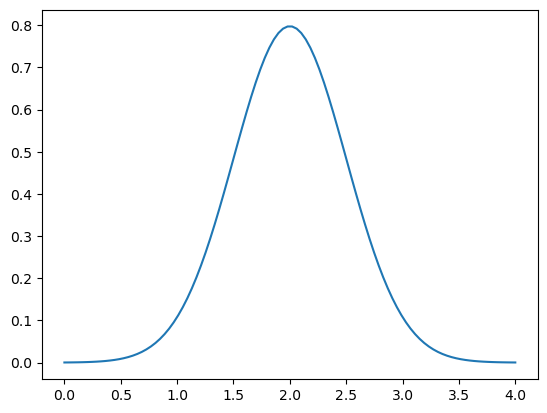

In [25]:
from scipy.stats import norm

def normal_PDF(x, mean, sd):
    con = 1 / np.sqrt(2 * np.pi * sd**2)
    exp = -0.5 * (x-mean)**2 / sd**2
    return con * np.exp(exp)

# Set x, mean and standard deviation
x = 0.5
mean = 2
sd = 0.5
my_pdf = normal_PDF(x, mean, sd)

# You can compare your outcome to scipy's built-in normal PDF
scipy_pdf = norm.pdf(x, mean, sd)
print("Your pdf function outcome: ", my_pdf, " Scipy's function outcome: ", scipy_pdf)
assert np.isclose(my_pdf, scipy_pdf)

# And we plot the result of your PDF function for 100 points between 0 and 4: np.linspace(0, 4, 100)
xs = np.linspace(0, 4, 100)
plt.plot(xs, normal_PDF(xs, mean, sd))
plt.show()

We already made estimates for $\mu$ and $\sigma$ for the *petal length* for each of the 3 classes, so we can now also define PDFs for each separate class.

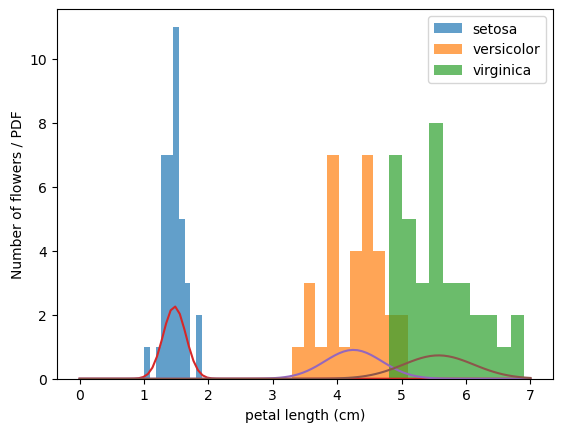

In [26]:
# Histograms of the flower types of the training set
plt.hist(setosa_X_train[:,feature_idx], label=iris.target_names[0], alpha=0.7)
plt.hist(versicolor_X_train[:,feature_idx], label=iris.target_names[1], alpha=0.7)
plt.hist(virginica_X_train[:,feature_idx], label=iris.target_names[2], alpha=0.7)

# Plot your PDFs here
xs = np.linspace(0, 7, 100)

plt.plot(xs, normal_PDF(xs, np.mean(setosa_X_train[:, feature_idx]), np.std(setosa_X_train[:, feature_idx])))
plt.plot(xs, normal_PDF(xs, np.mean(versicolor_X_train[:, feature_idx]), np.std(versicolor_X_train[:, feature_idx])))
plt.plot(xs, normal_PDF(xs, np.mean(virginica_X_train[:, feature_idx]), np.std(virginica_X_train[:, feature_idx])))

plt.xlabel(iris.feature_names[feature_idx])
plt.ylabel('Number of flowers / PDF')
plt.legend()
plt.show()

## 6. Posterior probabilities

To get the posterior probability, we can use Bayes' rule:

$$P(C_i | x) =  \frac{p(x | C_i) P(C_i)}{p(x)} = \frac{p(x | C_i) P(C_i)}{\sum_{k=1}^K p(x | C_k) P(C_k)}$$

We will construct our classifier such that, after observing a datapoint $x$, we assign the point to the class $C_i$ with the higest $P(C_i | x)$, so to the class which is most likely.

In [27]:
def posterior(x, means, sds, priors, i):
    """
    Compute the posterior probability P(C_i | x).
    :param x: the sample to compute the posterior probability for.
    :param means: an array of means for each class.
    :param sds: an array of standard deviation values for each class.
    :param priors: an array of frequencies for each class.
    :param i: the index of the class to compute the posterior probability for.
    """

    top = normal_PDF(x, means[i], sds[i]) * priors[i]
    bottom = sum([normal_PDF(x, means[i], sds[i]) * priors[i] for i in range(3)])
    return top / bottom

means = [mean_setosa, mean_versicolor, mean_virginica]
sds = [sd_setosa, sd_versicolor, sd_virginica]
priors = [
    setosa_X_train.shape[0]/X_train.shape[0],
    versicolor_X_train.shape[0]/X_train.shape[0],
    virginica_X_train.shape[0]/X_train.shape[0]
]

# Test out the code
flower_idx = 6
print("Flower belongs to class", iris.target_names[Y_train[flower_idx]])

# iterate over all classes
for i in range(3):
    x_post = posterior(X_train[flower_idx, feature_idx], means, sds, priors, i)
    print("Posterior probability for class", iris.target_names[i], ": ", x_post)

post_setosa = posterior(X_train[flower_idx, feature_idx], means, sds, priors, 0)
post_versicolor = posterior(X_train[flower_idx, feature_idx], means, sds, priors, 1)
post_virginica = posterior(X_train[flower_idx, feature_idx], means, sds, priors, 2)

assert np.isclose(post_setosa, 1.1048294835009998e-107, rtol = 0.0001, atol = 0.), "Expected a different posterior probability"
assert np.isclose(post_versicolor, 0.03817178391547811, rtol = 0.0001, atol = 0.), "Expected a different posterior probability"
assert np.isclose(post_virginica, 0.9618282160845218, rtol = 0.0001, atol = 0.), "Expected a different posterior probability"

Flower belongs to class virginica
Posterior probability for class setosa :  1.1048294835009998e-107
Posterior probability for class versicolor :  0.03817178391547814
Posterior probability for class virginica :  0.9618282160845218


Plot the posterior probabilities for all 3 classes.

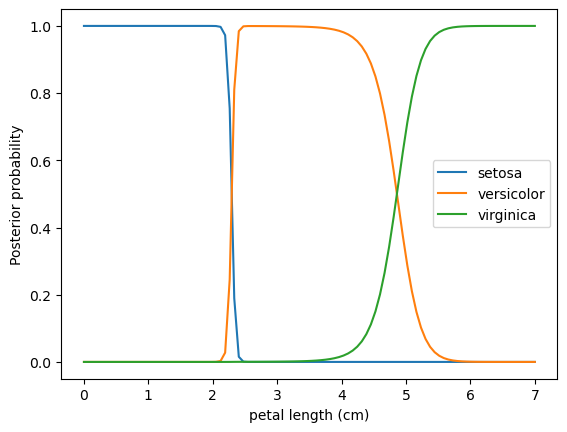

In [28]:
xs = np.linspace(0, 7, 100)

post_setosa_vals = [posterior(x, means, sds, priors, 0) for x in xs]
post_versicolor_vals = [posterior(x, means, sds, priors, 1) for x in xs]
post_virginica_vals = [posterior(x, means, sds, priors, 2) for x in xs]

plt.plot(xs, post_setosa_vals, label=iris.target_names[0])
plt.plot(xs, post_versicolor_vals, label=iris.target_names[1])
plt.plot(xs, post_virginica_vals, label=iris.target_names[2])

plt.xlabel(iris.feature_names[feature_idx])
plt.ylabel('Posterior probability')
plt.legend()
plt.show()

## 7. Bayes Classifier

Now that we can compute the posteriors for every class, constructing a classifier is easy. The Bayes classifier is defined as

- Classify as $C_i$ for which: $i = argmax_i\ P(C_i |x)$

In [29]:
def classify(x, means, sds, priors):
    a = posterior(x, means, sds, priors, 0)
    b = posterior(x, means, sds, priors, 1)
    c = posterior(x, means, sds, priors, 2)
    if a >= b and a >= c:
        return 0
    elif b >= a and b >= c:
        return 1
    elif c >= a and c >= b:
        return 2

# Test out the code
flower_idxs = [5,20,30]
predicted_classes = np.zeros(3, dtype=np.int64)
for i, flower_idx in enumerate(flower_idxs):
    predicted_classes[i] = classify(X_train[flower_idx, feature_idx], means, sds, priors)

print("Predicted class", iris.target_names[predicted_classes])
print("Flower belongs to class", iris.target_names[Y_train[flower_idxs]])
assert (predicted_classes == Y_train[flower_idxs]).all()

Predicted class ['virginica' 'versicolor' 'setosa']
Flower belongs to class ['virginica' 'versicolor' 'setosa']


Finally evaluate the accuracy.

In [30]:
def evaluate(X_test, Y_test, means, sds, priors):
    good = 0
    for i in range(len(X_test)):
        if classify(X_test[i], means, sds, priors) == Y_test[i]:
            good += 1
    return good/len(X_test)

accuracy = evaluate(X_test[:, feature_idx], Y_test, means, sds, priors)

print(accuracy)
assert accuracy > 0.9, "Expected a higher accuracy"

0.9555555555555556


Let's return to our scatterplots and see how your classifier makes decisions. For this, we also plot the decision boundary. The function to create the decision boundaries does this in a very simple way:
- For each class, compute the posterior for 1000 points between 1 and 7
- If for any two classes the posteriors are as good as equal (and not very close to 0) at a point, add that point to the list of decision boundaries
- Plot vertical lines at these points

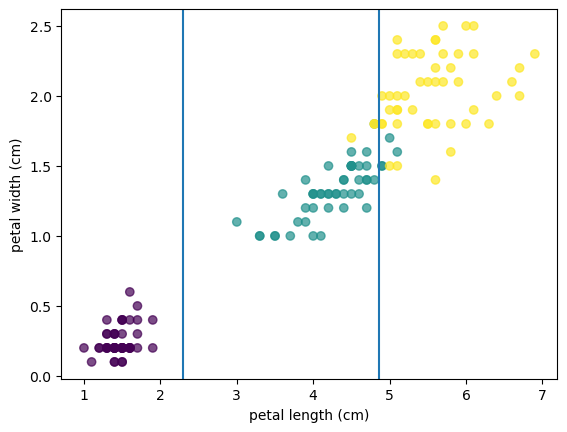

In [31]:
def decision_boundary(means, sds, priors):
    decision_boundaries = []
    xs = np.linspace(1, 7, 1000)

    l, r = 0, 500
    while l <= r:
        mid = (l+r)//2
        if (posterior(xs[mid], means, sds, priors, 0) > posterior(xs[mid], means, sds, priors, 1)):
            l = mid + 1
        else:
            r = mid - 1
    decision_boundaries.append(xs[l])

    l, r = 500, 999
    while l <= r:
        mid = (l+r)//2
        if (posterior(xs[mid], means, sds, priors, 1) > posterior(xs[mid], means, sds, priors, 2)):
            l = mid + 1
        else:
            r = mid - 1
    decision_boundaries.append(xs[l])

    return decision_boundaries

# Create a scatterplot of the third and fourth feature.
feature_idx2 = 3

plt.scatter(iris.data[:, feature_idx], iris.data[:, feature_idx2], c=iris.target, alpha=0.7)
plt.xlabel(iris.feature_names[feature_idx])
plt.ylabel(iris.feature_names[feature_idx2])
decision_boundaries = decision_boundary(means, sds, priors)
for boundary in decision_boundaries:
    plt.axvline(x=boundary)

plt.show()